We will use the [CartPole-v1](https://gym.openai.com/envs/CartPole-v0/) OpenAI Gym environment. For reproducibility, let is fix a random seed.

In [1]:
from reagent.gym.envs.gym import Gym

env = Gym('CartPole-v0')

I1120 110456.710 dataclasses.py:49] USE_VANILLA_DATACLASS: True
I1120 110456.712 dataclasses.py:50] ARBITRARY_TYPES_ALLOWED: True
I1120 110456.736 io.py:19] Registered Manifold PathManager
I1120 110456.984 patch.py:95] Patched torch.load, torch.save, torch.jit.load and save to handle Manifold uri
I1120 110457.027 registry_meta.py:19] Adding REGISTRY to type TrainingReport
I1120 110457.028 registry_meta.py:40] Not Registering TrainingReport to TrainingReport. Abstract method [] are not implemented.
I1120 110457.029 registry_meta.py:19] Adding REGISTRY to type PublishingResult
I1120 110457.030 registry_meta.py:40] Not Registering PublishingResult to PublishingResult. Abstract method [] are not implemented.
I1120 110457.031 registry_meta.py:19] Adding REGISTRY to type ValidationResult
I1120 110457.032 registry_meta.py:40] Not Registering ValidationResult to ValidationResult. Abstract method [] are not implemented.
I1120 110457.033 registry_meta.py:31] Registering NoPublishingResults to Pu

In [2]:
import numpy as np
import torch

def reset_env(env, seed):
    np.random.seed(seed)
    env.seed(seed)
    env.action_space.seed(seed)
    torch.manual_seed(seed)
    env.reset()

reset_env(env, seed=0)

The `policy` is composed of a simple scorer (a MLP) and a softmax sampler. Our `agent` simply executes this policy in the CartPole Environment.

In [3]:
from reagent.net_builder.discrete_dqn.fully_connected import FullyConnected
from reagent.gym.utils import build_normalizer

norm = build_normalizer(env)
net_builder = FullyConnected(sizes=[8], activations=["linear"])
cartpole_scorer = net_builder.build_q_network(
    state_feature_config=None, 
    state_normalization_data=norm['state'],
    output_dim=len(norm['action'].dense_normalization_parameters))

I1120 110457.591 registry_meta.py:19] Adding REGISTRY to type DiscreteDQNNetBuilder
I1120 110457.592 registry_meta.py:40] Not Registering DiscreteDQNNetBuilder to DiscreteDQNNetBuilder. Abstract method ['build_q_network'] are not implemented.
I1120 110457.592 registry_meta.py:31] Registering Dueling to DiscreteDQNNetBuilder
I1120 110457.593 dataclasses.py:74] Setting Dueling.__post_init__ to its __post_init_post_parse__
I1120 110457.595 registry_meta.py:31] Registering FullyConnected to DiscreteDQNNetBuilder
I1120 110457.596 dataclasses.py:74] Setting FullyConnected.__post_init__ to its __post_init_post_parse__
I1120 110457.597 registry_meta.py:31] Registering FullyConnectedWithEmbedding to DiscreteDQNNetBuilder
I1120 110457.597 dataclasses.py:74] Setting FullyConnectedWithEmbedding.__post_init__ to its __post_init_post_parse__


In [4]:
from reagent.gym.policies.policy import Policy
from reagent.gym.policies.samplers.discrete_sampler import SoftmaxActionSampler
from reagent.gym.agents.agent import Agent


policy = Policy(scorer=cartpole_scorer, sampler=SoftmaxActionSampler())
agent = Agent.create_for_env(env, policy)

Create a trainer that uses the REINFORCE Algorithm to train.

In [5]:
from reagent.training.reinforce import (
    Reinforce, ReinforceParams
)
from reagent.optimizer.union import classes


trainer = Reinforce(policy, ReinforceParams(
    gamma=0.99,
    optimizer=classes['Adam'](lr=5e-3, weight_decay=1e-3)
))

Transform the trajectory of observed transitions into a training batch

In [6]:
import torch.nn.functional as F
import reagent.types as rlt


def to_train_batch(trajectory):
    return rlt.PolicyGradientInput(
        state=rlt.FeatureData(torch.from_numpy(np.stack(trajectory.observation)).float()),
        action=F.one_hot(torch.from_numpy(np.stack(trajectory.action)), 2),
        reward=torch.tensor(trajectory.reward),
        log_prob=torch.tensor(trajectory.log_prob)
    )


RL Interaction Loop

In [7]:
from reagent.gym.runners.gymrunner import evaluate_for_n_episodes

In [8]:
eval_rewards = evaluate_for_n_episodes(100, env, agent, 500, num_processes=20)

I1120 110458.392 gymrunner.py:134] For gamma=1.0, average reward is 17.7
Rewards list: [14. 23. 14. 23. 14. 23. 14. 23. 14. 23. 14. 23. 14. 23. 14. 23. 14. 23.
 14. 23. 14. 23. 14. 23. 14. 23. 14. 23. 14. 23. 14. 23. 14. 23. 14. 23.
 14. 23. 14. 23. 25. 13. 25. 13. 25. 13. 25. 13. 25. 13. 25. 13. 25. 13.
 25. 13. 25. 13. 25. 13. 25. 13. 25. 13. 25. 13. 25. 13. 25. 13. 25. 13.
 25. 13. 25. 13. 25. 13. 25. 13. 13. 14. 13. 14. 13. 14. 13. 14. 13. 14.
 13. 14. 13. 14. 13. 14. 13. 14. 13. 14.]


In [9]:
num_episodes = 500
reward_min = 20
max_steps = 500
reward_decay = 0.8

train_rewards = []
running_reward = reward_min


import tqdm.autonotebook as tqdm
from reagent.gym.runners.gymrunner import run_episode


with tqdm.trange(num_episodes, unit=" epoch") as t:
    for i in t:
        trajectory = run_episode(env, agent, max_steps=max_steps, mdp_id=i)
        batch = to_train_batch(trajectory)
        trainer.train(batch)
        ep_reward = trajectory.calculate_cumulative_reward(1.0)
        running_reward *= reward_decay
        running_reward += (1 - reward_decay) * ep_reward
        train_rewards.append(ep_reward)
        t.set_postfix(reward=running_reward)



100%|██████████| 500/500 [00:34<00:00, 14.37 epoch/s, reward=200] 


Print the mean reward.

In [10]:
eval_episodes = 200
eval_rewards = evaluate_for_n_episodes(100, env, agent, 500, num_processes=20).T[0]

I1120 110534.523 gymrunner.py:134] For gamma=1.0, average reward is 200.0
Rewards list: [200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200.]


In [11]:
import pandas as pd

mean_reward = pd.Series(eval_rewards).mean()
print(f'Mean reward: {mean_reward:.2f}')

Mean reward: 200.00


Plot the rewards over training episodes.

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns

def plot_rewards(rewards):
    fig, ax = plt.subplots(1, 1, figsize=(12, 10));
    pd.Series(rewards).rolling(50).mean().plot(ax=ax);
    pd.Series(rewards).plot(ax=ax,alpha=0.5,color='lightblue');
    ax.set_xlabel('Episodes');
    ax.set_ylabel('Reward');
    plt.title('REINFORCE on CartPole');
    plt.legend(['Moving Average Reward', 'Instantaneous Episode Reward'])
    return fig, ax

sns.set_style('darkgrid')
sns.set()


plot_rewards(train_rewards);


Bad key "axes.color_cycle" on line 214 in
/home/alexnik/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


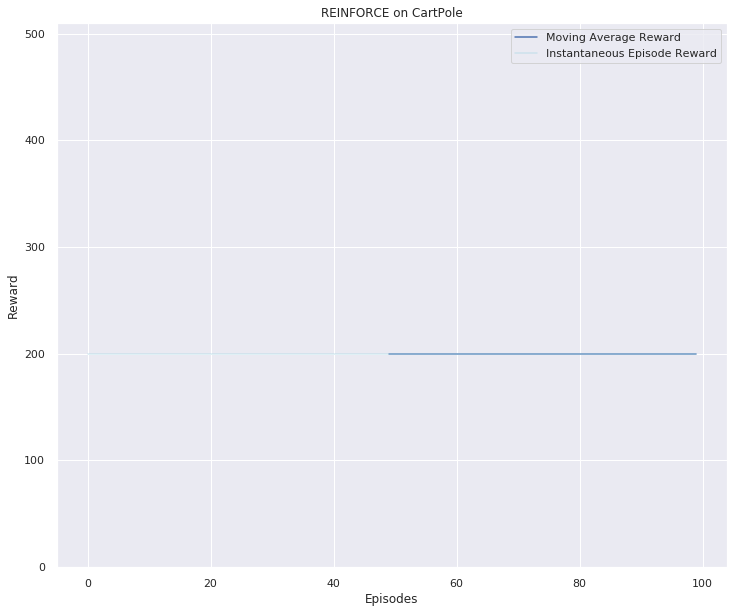

In [13]:
plot_rewards(eval_rewards);
plt.ylim([0, 510]);